# Adaptive hyperparameter optimization
This notebook shows off a model selection algorithm that is now a part of Dask-ML, Hyperband.

## Problem
Any machine learning model requires tuning many "hyper-parameters" for good performance, and is mentioned in the Scikit-Learn docs under "[Tuning the hyper-parameters of an estimator]".

This notebook will walk through a case of "image denoising". Getting good performance out of this model requires tuning these parameters:

``` python
params = {
    'module__init',
    'module__activation',
    'optimizer',
    'batch_size',
    'optimizer__lr',
    'optimizer__weight_decay',
}
```

These are incredibly important, and fairly basic. They answer the questions of

* How is the network initialization?
* How is the model optimized? What are some of the hyper-parameters for `optimizer`?

[Tuning the hyper-parameters of an estimator]:http://scikit-learn.org/stable/modules/grid_search.html


This notebook looks at a realistic use case of hyperparameter optimization. To do this, this notebook uses

* a realistic deep learning model
* a realistic set of hyperparameters

There are many hyperparameter for any model or framework. These can be specific to the model, or be related to the optimization framework used to minimize the model.

This notebook will show

* the model input and output (noisy and clean images respectively)
* the parameter space we are searching over
* a newly developed hyperparameter optimization algorithm and it's integration
* a comparison with 3 hyperparameter selection algorithms

## Setup

In [1]:
%matplotlib inline
# %load_ext autoreload
# %autoreload 2

In [2]:
import distributed
from distributed import Client, LocalCluster
cluster = LocalCluster(n_workers=16)
client = Client(cluster)
client

Client Scheduler: tcp://127.0.0.1:41687 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 16 Cores: 48 Memory: 98.35 GB


In [3]:
import subprocess
def debug_loop():
    subprocess.call("pip install git+https://github.com/stsievert/dask-ml@hyperband-scale".split(" "))
    import dask_ml
    return dask_ml.__version__

In [4]:
%time debug_loop()

CPU times: user 389 ms, sys: 66 ms, total: 455 ms
Wall time: 4.24 s


'0.4.2.dev510+gf8aa788'

In [5]:
client.run(debug_loop)

{'tcp://127.0.0.1:34347': '0.4.2.dev510+gf8aa788',
 'tcp://127.0.0.1:35247': '0.4.2.dev510+gf8aa788',
 'tcp://127.0.0.1:35907': '0.4.2.dev510+gf8aa788',
 'tcp://127.0.0.1:37539': '0.4.2.dev510+gf8aa788',
 'tcp://127.0.0.1:37759': '0.4.2.dev510+gf8aa788',
 'tcp://127.0.0.1:40139': '0.4.2.dev510+gf8aa788',
 'tcp://127.0.0.1:40181': '0.4.2.dev510+gf8aa788',
 'tcp://127.0.0.1:40571': '0.4.2.dev510+gf8aa788',
 'tcp://127.0.0.1:41317': '0.4.2.dev510+gf8aa788',
 'tcp://127.0.0.1:41377': '0.4.2.dev510+gf8aa788',
 'tcp://127.0.0.1:41833': '0.4.2.dev510+gf8aa788',
 'tcp://127.0.0.1:41993': '0.4.2.dev510+gf8aa788',
 'tcp://127.0.0.1:42593': '0.4.2.dev510+gf8aa788',
 'tcp://127.0.0.1:45215': '0.4.2.dev510+gf8aa788',
 'tcp://127.0.0.1:46589': '0.4.2.dev510+gf8aa788',
 'tcp://127.0.0.1:46601': '0.4.2.dev510+gf8aa788'}

In [6]:
%time client.restart()

CPU times: user 328 ms, sys: 26.9 ms, total: 355 ms
Wall time: 734 ms


Client Scheduler: tcp://127.0.0.1:41687 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 16 Cores: 48 Memory: 98.35 GB


In [7]:
%time client.upload_file('autoencoder.py')

CPU times: user 75.4 ms, sys: 20.7 ms, total: 96.1 ms
Wall time: 749 ms


In [8]:
import dask_ml
from dask_ml.model_selection import HyperbandSearchCV
import dask_ml
dask_ml.__version__

'0.4.2.dev510+gf8aa788'

## Data
See below for an image.

In [9]:
import noisy_mnist
_X, _y = noisy_mnist.dataset()#n=10 * 1024)

Using TensorFlow backend.


In [10]:
import dask.array as da
n, d = _X.shape
X = da.from_array(_X, chunks=(n // 3, d))
y = da.from_array(_y, chunks=n // 3)
X, y

(dask.array<array, shape=(70000, 784), dtype=float32, chunksize=(23333, 784)>,
 dask.array<array, shape=(70000, 784), dtype=float32, chunksize=(23333, 784)>)

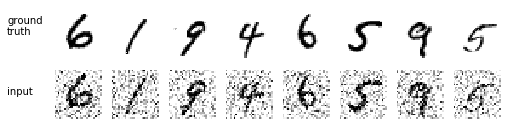

In [11]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
cols = 8
w = 1.0
fig, axs = plt.subplots(figsize=(cols*w, 2*w), ncols=cols, nrows=2)
for col, (upper, lower) in enumerate(zip(axs[0], axs[1])):
    if col == 0:
        upper.text(-28, 14, 'ground\ntruth')
        lower.text(-28, 14, 'input')
    i = np.random.choice(len(X))
    noisy = X[i].reshape(28, 28)
    clean = y[i].reshape(28, 28)
    kwargs = {'cbar': False, 'xticklabels': False, 'yticklabels': False, 'cmap': 'gray_r'}
    sns.heatmap(noisy, ax=lower, **kwargs)
    sns.heatmap(clean, ax=upper, **kwargs)
plt.savefig("imgs/input-output.svg", bbox_inches="tight")
plt.show()

## Model

I use a deep learning library (PyTorch) for this model, at least through the scikit-learn interface for PyTorch, [skorch].

[skorch]:https://github.com/dnouri/skorch

In [12]:
from autoencoder import Autoencoder, NegLossScore
import torch
# from sklearn.model_selection import ParameterSampler
import torch

def trim_params(**kwargs):
    if kwargs['optimizer'] != 'Adam':
        kwargs.pop('optimizer__amsgrad', None)
    if kwargs['optimizer'] == 'Adam':
        kwargs.pop('optimizer__lr', None)
    if kwargs['optimizer'] != 'SGD':
        kwargs.pop('optimizer__nesterov', None)
        kwargs.pop('optimizer__momentum', None)
    kwargs['optimizer'] = getattr(torch.optim, kwargs['optimizer'])
    return kwargs

class TrimParams(NegLossScore):
    def set_params(self, **kwargs):
        kwargs = trim_params(**kwargs)
        return super().set_params(**kwargs)

model = TrimParams(
    module=Autoencoder,
    criterion=torch.nn.BCELoss,
    warm_start=True,
    train_split=None,
    max_epochs=1,
    callbacks=[]
)

I don't show it here; I'd rather concentrate on tuning hyperparameters. But briefly, it's a simple fully connected 3 hidden layer autoencoder with a latent dimension of 49.

## Parameters

The parameters I am interested in tuning are

* model
    * initialization
    * activation function
    * weight decay (which is similar to $\ell_2$ regularization)
* optimizer
    * which optimizer to use (e.g., Adam, SGD)
    * batch size used to approximate gradient
    * learning rate (but not for Adam)
    * momentum for SGD
    
After looking at the results, I think I was too exploratory in my tuning of step size. I should have experimented with it more to determine a reasonable range.

In [13]:
import numpy as np

params = {
    'module__init': ['xavier_uniform_',
                     'xavier_normal_',
                     'kaiming_uniform_',
                     'kaiming_normal_',
                    ],
    'module__activation': ['ReLU', 'LeakyReLU', 'ELU', 'PReLU'],
    'optimizer': ["SGD"] * 5 + ["Adam"] * 2,
    'batch_size': [32, 64, 128, 256, 512],
    'optimizer__lr': np.logspace(1, -1.5, num=1000),
    'optimizer__weight_decay': [0]*200 + np.logspace(-5, -3, num=1000).tolist(),
    'optimizer__nesterov': [True],
    'optimizer__momentum': np.linspace(0, 1, num=1000),
    'train_split': [None],
}

I am testing `optimizer` to be `SGD` or `Adam` to test "[The Marginal Value of Adaptive Gradient Methods in Machine Learning][marginal]". From their abstract,

> We observe that the solutions found by adaptive methods generalize worse (often sig- nificantly worse) than SGD, even when these solutions have better training performance. These results suggest that practitioners should reconsider the use of adaptive methods to train neural networks.

Their experiments in Figure 1b show that non-adaptive methods (SGD and heavy ball) perform much better than adaptive methods.

They have to do some tuning for this. **Can we replicate their result?**

[marginal]:https://arxiv.org/pdf/1705.08292.pdf

In [14]:
# # for debugging; ignore this cell
# from sklearn.linear_model import SGDClassifier
# from sklearn.datasets import make_classification
# from sklearn.model_selection import ParameterSampler
# import dask.array as da
# import numpy as np
# model = SGDClassifier()
# params = {'alpha': np.logspace(-7, 0, num=int(1e6))}

# n, d = int(10e3), 700
# _X, _y = make_classification(n_samples=n, n_features=d,
#                              random_state=1)
# X = da.from_array(_X, chunks=(n // 10, d))
# y = da.from_array(_y, chunks=n // 10)
# X, y

In [15]:
import json
import msgpack

def fmt(obj):
    if isinstance(obj, list):
        return [fmt(v) for v in obj]
    if isinstance(obj, dict):
        return {k: fmt(v) for k, v in obj.items()}
    if isinstance(obj, np.ndarray):
        return obj.tolist()
    return obj

import msgpack
from sklearn.externals import joblib

def save_search(search, today, prefix, X, y):
    pre = f"{today}-{prefix}-"

    with open(pre + "test.npz", "wb") as f:
        y_hat = search.predict(X)
        np.savez(f, X=X, y=y, y_hat=y_hat)
    # skorch models aren't pickable
    with open(pre + "hyperband-params.json", "w") as f:
        params = {k: fmt(v) for k, v in search.get_params().items() if "estimator" not in k}
        json.dump(params, f)
    # with open(pre + "best-model.joblib", "wb") as f:
    #     joblib.dump(search.best_estimator_, f)
    with open(pre + "best-params-and-score.json", "w") as f:
        json.dump({"params": search.best_params_, "score": search.best_score_}, f)

    with open(pre + "history.json", 'w') as f:
        json.dump(search.history_, f)

    with open(pre + "cv_results.json", 'w') as f:
        json.dump(fmt(search.cv_results_), f)

In [16]:
today = "2019-01-06"

## Hyperparameter optimization

In [19]:
from dask_ml.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)
X_train, X_test

(dask.array<concatenate, shape=(62997, 784), dtype=float32, chunksize=(20999, 784)>,
 dask.array<concatenate, shape=(7003, 784), dtype=float32, chunksize=(2334, 784)>)

In [20]:
from sklearn.linear_model import SGDClassifier

max_iter = 243
history = {}
cv_results = {}
searches = {}

In [21]:
from dask_ml.model_selection import HyperbandSearchCV

fit_params = {}
if isinstance(model, SGDClassifier):
    fit_params = {'classes': da.unique(y).compute()}
   

### Hyperband

In [22]:
search = HyperbandSearchCV(model, params, max_iter, random_state=0)

In [23]:
search.fit(X_train, y_train, **fit_params)

KeyboardInterrupt: 

distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker


In [34]:
search.best_estimator_

<class '__main__.TrimParams'>[initialized](
  module_=Autoencoder(
    (encoder): Sequential(
      (0): Linear(in_features=784, out_features=196, bias=True)
      (1): LeakyReLU(negative_slope=0.01, inplace)
      (2): Linear(in_features=196, out_features=49, bias=True)
      (3): LeakyReLU(negative_slope=0.01, inplace)
    )
    (decoder): Sequential(
      (0): Linear(in_features=49, out_features=784, bias=True)
      (1): Sigmoid()
    )
  ),
)

In [35]:
search.best_score_

-0.1260516494512558

In [36]:
search.best_params_

{'train_split': None,
 'optimizer__weight_decay': 1.9874595495809818e-05,
 'optimizer__nesterov': True,
 'optimizer__momentum': 0.6216216216216216,
 'optimizer__lr': 0.09783415323388789,
 'optimizer': 'Adam',
 'module__init': 'kaiming_uniform_',
 'module__activation': 'LeakyReLU',
 'batch_size': 128}

In [33]:
save_search(search, today, "hyperband", X_test.compute(), y_test.compute())

### Hyperband + SOP

In [39]:
search_patience = HyperbandSearchCV(model, params, max_iter, random_state=0, patience=True)

In [40]:
search_patience.fit(X_train, y_train, **fit_params)

HyperbandSearchCV(aggressiveness=3,
         estimator=<class '__main__.TrimParams'>[uninitialized](
  module=<class 'autoencoder.Autoencoder'>,
),
         max_iter=243,
         param_distribution={'module__init': ['xavier_uniform_', 'xavier_normal_', 'kaiming_uniform_', 'kaiming_normal_'], 'module__activation': ['ReLU', 'LeakyReLU', 'ELU', 'PReLU'], 'optimizer': ['SGD', 'SGD', 'SGD', 'SGD', 'SGD', 'Adam', 'Adam'], 'batch_size': [32, 64, 128, 256, 512], 'optimizer__lr': arr...ov': [True], 'optimizer__momentum': array([0.   , 0.001, ..., 0.999, 1.   ]), 'train_split': [None]},
         patience=True, random_state=17737, scores_per_fit=1, scoring=None,
         test_size=None, tol=0.001)

In [63]:
save_search(search_patience, today, "hyperband-w-patience", X_test.compute(), y_test.compute())

In [ ]:
search.best_estimator_

In [ ]:
search.best_score_

In [ ]:
search.best_params_

### Visualizing output of best estimator

In [37]:
noisy_test = X_test.compute()

In [38]:
clean_hat = search.best_estimator_.predict(noisy_test)
clean_hat.shape

(7003, 784)

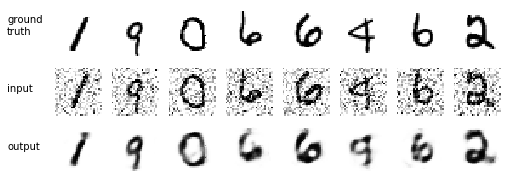

In [39]:
cols = 8
w = 1.0
fig, axs = plt.subplots(figsize=(cols*w, 3*w), ncols=cols, nrows=3)
for col, (upper, middle, lower) in enumerate(zip(axs[0], axs[1], axs[2])):
    if col == 0:
        upper.text(-28, 14, 'ground\ntruth')
        middle.text(-28, 14, 'input')
        lower.text(-28, 14, 'output')
    i = np.random.choice(len(X_test))
    noisy = X_test[i].reshape(28, 28)
    clean = y_test[i].reshape(28, 28)
    clean_hat_i = clean_hat[i].reshape(28, 28)
    kwargs = {'cbar': False, 'xticklabels': False, 'yticklabels': False, 'cmap': 'gray_r'}
    sns.heatmap(noisy, ax=middle, **kwargs)
    sns.heatmap(clean, ax=upper, **kwargs)
    sns.heatmap(clean_hat_i, ax=lower, **kwargs)
plt.savefig("imgs/best-out.svg", bbox_inches="tight")
plt.show()

### Setting parameters for Hyperband
Need to know two things:

1. how many "epochs" or "passes through data" to train model
2. how many configs to evaluate
    * this is some measure of how complex the search space is
    
This determines

* The `max_iter` argument for `HyperbandCV`
* the chunks size for the array to pass in


## Comparison with early stopping

In [71]:
total_calls = search.metadata_['partial_fit_calls']
num_calls = max_iter

n_workers = len(client.cluster.workers)
num_models = max(n_workers, total_calls // num_calls)
num_calls, num_models, search.metadata_['partial_fit_calls']

(243, 32, 4743)

In [96]:
from dask_ml.model_selection import IncrementalSearchCV

# passive_search = IncrementalSearchCV(
#     model, params,
#     decay_rate=0,
#     patience=False,
#     n_initial_parameters=num_models,
#     max_iter=num_calls,
#     random_state=0
# )

In [ ]:
# passive_search.fit(X_train, y_train, **fit_params)

In [ ]:
# save_search(passive_search, today, "passive", X_test.compute(), y_test.compute())

* patience: `max_iter // 8` (10 epochs)
* n_initial: `2 * num_models`

This requires choosing

* the explore/exploit tradeoff (`patience` vs `n_initial`)
* some estimate on many models will take advantage of `patience` to get total number of partial fit calls

In [100]:
patience_search = IncrementalSearchCV(
    model,
    params,
    decay_rate=0,
    patience=max_iter // 10,
    n_initial_parameters=2 * num_models,
    max_iter=num_calls,
    random_state=0,
)

In [101]:
patience_search.fit(X_train, y_train, **fit_params)

IncrementalSearchCV(decay_rate=0,
          estimator=<class '__main__.TrimParams'>[uninitialized](
  module=<class 'autoencoder.Autoencoder'>,
),
          max_iter=243, n_initial_parameters=64, param_distribution=None,
          patience=30, random_state=0, scores_per_fit=1, scoring=None,
          test_size=None, tol=0.001)

In [102]:
save_search(patience_search, today, "patience", X_test.compute(), y_test.compute())